In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd

## JPDB Stats
**Instructions to Use**
In order to run this, you just need to put the JSON from your exported review history in the same directory that you are running this notebook out of, then re-run the cells.

In [2]:
with open('vocabulary-reviews.json', 'r') as f:
    reviews_json = json.load(f)

reviews_list = []
new_words = []
review_counts = []
for entry in reviews_json["cards_vocabulary_jp_en"]:
    review_counts.append([entry['spelling'], len(entry['reviews']), datetime.utcfromtimestamp(entry['reviews'][0]['timestamp']).date(), entry['reviews'][0]['from_anki']])
    new_words.append(datetime.utcfromtimestamp(entry['reviews'][0]['timestamp']).date())
    for review in entry['reviews']:
        reviews_list.append(datetime.utcfromtimestamp(review['timestamp']).date())


### New Words

Here are two graphs showing just the new words that were added to your reviews as a cumulative count and as a daily count. These counts do no include redundant cards (unless you reviewed them) and does not count cards that were marked 'never forget'.

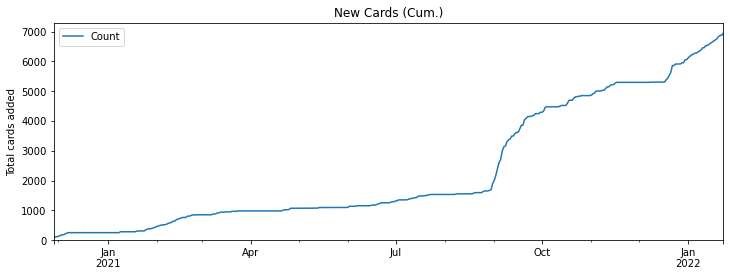

In [3]:
new = pd.DataFrame(new_words, columns=['Date added'])
new['Count'] = 1
new = new.groupby('Date added').sum()
new.head()

idx = pd.date_range(new.index.min(), new.index.max())
new.index = pd.DatetimeIndex(new.index)
new = new.reindex(idx, fill_value=0)
new_cum = new.cumsum()
ax = new_cum.plot(figsize=(12, 4))
ax.set_ylabel("Total cards added")
ax.set_title("New Cards (Cum.)")
ax.set_ylim(bottom=0)
plt.show()

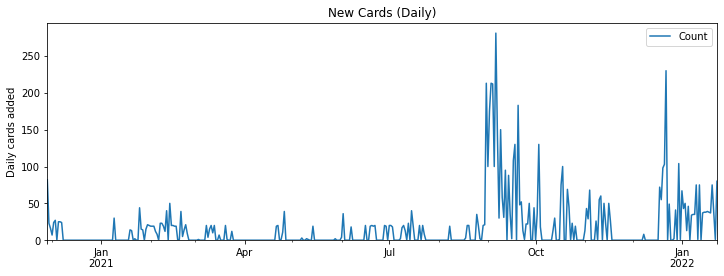

In [4]:
ax = new.plot(figsize=(12, 4))
ax.set_ylabel("Daily cards added")
ax.set_title("New Cards (Daily)")
ax.set_ylim(bottom=0)
plt.show()

### Reviews

Here are two graphs showing just your reviews as a cumulative count and as a daily count.

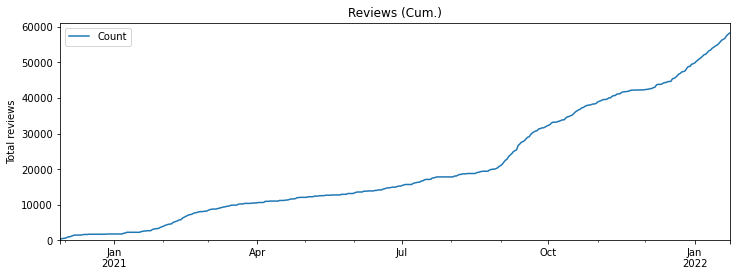

In [5]:
reviews = pd.DataFrame(reviews_list, columns=['Date'])
reviews['Count'] = 1
reviews = reviews.groupby('Date').sum()

idx = pd.date_range(reviews.index.min(), reviews.index.max())
reviews.index = pd.DatetimeIndex(reviews.index)
reviews = reviews.reindex(idx, fill_value=0)
reviews_cum = reviews.cumsum()
ax = reviews_cum.plot(figsize=(12, 4))
ax.set_ylabel("Total reviews")
ax.set_title("Reviews (Cum.)")
ax.set_ylim(bottom=0)
plt.show()

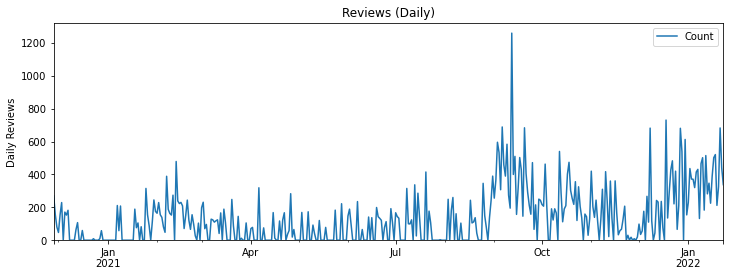

In [6]:
ax = reviews.plot(figsize=(12, 4))
ax.set_ylabel("Daily Reviews")
ax.set_title("Reviews (Daily)")
ax.set_ylim(bottom=0)
plt.show()

### Retention

These are both all time numbers for retention by hour of the day (in UTC) and retention by whether the interval was longer than 3 or 30 days prior to the review.

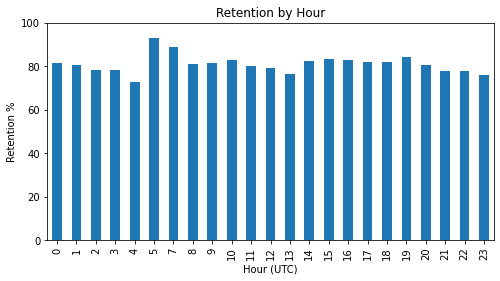

In [7]:
full_history = []

def is_successful(string):
    if string in ['known', 'pass', 'hard', 'easy', 'okay']:
        return 1
    return 0

# The idea here is not to count reviews that are either the first review for a word or reviews that aren't the first review of the day
def parse_entry(entry):
    history = []
    previous = None
    for review in entry['reviews']:
        interval = None
        if previous is not None:
            interval = review['timestamp'] - previous['timestamp']
        if (previous is not None) and (datetime.utcfromtimestamp(previous['timestamp']).date() != datetime.utcfromtimestamp(review['timestamp']).date()):
            history.append([datetime.utcfromtimestamp(review['timestamp']).time().hour, interval, is_successful(review['grade']), 1])
        previous = review
    return history
        

for entry in reviews_json["cards_vocabulary_jp_en"]:
    full_history += parse_entry(entry)

retention = pd.DataFrame(full_history, columns=['Hour (UTC)', 'Interval', 'Success', 'Total'])

retention_by_hour = retention.groupby('Hour (UTC)').sum()
retention_by_hour['Retention'] = 100 * retention_by_hour['Success'] / retention_by_hour['Total']
ax = retention_by_hour['Retention'].plot(kind='bar', figsize=(8, 4))
ax.set_ylabel("Retention %")
ax.set_title("Retention by Hour")
ax.set_ylim(bottom=0, top=100)
plt.show()

In [8]:
retention['Interval Type'] = pd.cut(retention['Interval'], bins=[0, 259200, 2592000, 999999999999], labels=['Learning', 'Young (>3 days)', 'Mature (>30 days)'])
retention_by_interval = retention.groupby('Interval Type').sum()
retention_by_interval['Retention'] = 100 * retention_by_interval['Success'] / retention_by_interval['Total']
retention_by_interval = retention_by_interval.drop(['Interval', 'Hour (UTC)', 'Success', 'Total'], 1)
retention_by_interval

,Retention
Interval Type,
Learning,76.657272
Young (>3 days),80.502567
Mature (>30 days),86.664632


### Trouble Words

The theory behind this table is that the words with the most reviews are 'leeches' since words you get right frequently will go to long review intervals before accumulating many reviews. Below you can set whether to include or exclude words that you had started to learn with Anki (may be useful if you had complex learning phase/relapse review cycles that added many reviews).

**TODO:** I think there is probably a better way to determine trouble words, since all words will eventually tend toward having many reviews given enough time.

In [9]:
exclude_anki = False;

In [10]:
cnt_df = pd.DataFrame(review_counts, columns=['Word', 'Review Count', 'Date added', 'From Anki'])
cnt_df = cnt_df.sort_values('Review Count', ascending=False)
if exclude_anki:
    cnt_df = cnt_df[cnt_df['From Anki'] == False]
cnt_df.head(25)

,Word,Review Count,Date added,From Anki
3201,傾く,48,2021-09-09,False
3202,行う,47,2021-02-13,True
3640,掲載,47,2021-09-04,False
4101,遠慮,46,2021-02-11,True
3275,責任,46,2021-02-13,True
4532,機会,45,2021-03-10,True
2365,資料,45,2021-07-10,True
6077,握る,44,2021-02-01,True
5692,佇む,44,2021-09-09,False
3130,短い,44,2021-03-20,True
